In [2]:
import os
home = os.path.expanduser("~")

import numpy as np
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
import seaborn as sns
snscolors=sns.color_palette()
snscolors=np.tile(np.array(snscolors),(10,1))
import scipy
import pickle
import gc
import time
import importlib


import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
imagedir = '../image-output/'

# Data Definitions and import

In [4]:
import datafunctions as dfunc


In [5]:
datadir = '/media/jacob/JD_DATA/zfish/'
resultdir = 'savedresults/'

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

# immport combined quantiles
outfile = resultdir+'combinedquantiles.pkl'
[all_speedquantiles10, all_speedquantiles20, all_ndistquantiles, all_bdistquantiles] = pickle.load(open(outfile,'rb'))

numfish=6

In [6]:
np.array(treatments)[focustreatments]

array(['WT', 'immp2lHO', 'ctnnd2bHO', 'scn1labHT', 'disc1KO', 'chrna2aHO'],
      dtype='<U10')

# View and make video of a certain line/trial

In [7]:
def makepolygon(pos,heading,fishlength,widthratio,centroidshift=0.3):
    a = widthratio
    theta = np.arctan2(1/2*(a-a**3/(1+a**2)+a*np.sqrt(4+3*a**2)/(1+a**2)),(-a**2+np.sqrt(4+3*a**2)/2/(1+a**2))  )
    slen = fishlength/(2*np.cos(theta)+1)
    
    # make a 6 sided figure
    numparticles=len(pos)
    fishsegments=np.zeros([numparticles,6,2,2])
    
    front_x, front_y = pos[:,0]+centroidshift*fishlength*np.cos(heading), pos[:,1]+centroidshift*fishlength*np.sin(heading)
    back_x, back_y = pos[:,0]-(1-centroidshift)*fishlength*np.cos(heading), pos[:,1]-(1-centroidshift)*fishlength*np.sin(heading)
    fr_x, fr_y = front_x-slen*np.cos(heading+theta), front_y-slen*np.sin(heading+theta)
    fl_x, fl_y = front_x-slen*np.cos(heading-theta), front_y-slen*np.sin(heading-theta) 
    br_x, br_y = back_x+slen*np.cos(heading-theta), back_y+slen*np.sin(heading-theta)        
    bl_x, bl_y = back_x+slen*np.cos(heading+theta), back_y+slen*np.sin(heading+theta)
    points = np.array([[front_x, front_y], [fr_x, fr_y], [br_x,br_y], [back_x,back_y], [bl_x,bl_y], [fl_x,fl_y]])
    for i in range((6)):
        fishsegments[:,i,0]=points[i].T
        fishsegments[:,i,1]=points[np.mod(i+1,6)].T
    
    ex, ey = np.mean([front_x,front_x,fr_x,fl_x],axis=0), np.mean([front_y,front_y,fr_y,fl_y],axis=0)
    
    lefteye = np.array([ex + widthratio/2*fishlength*np.cos(heading+np.pi/2), ey + widthratio/2*fishlength*np.sin(heading+np.pi/2)]).T
    righteye = np.array([ex + widthratio/2*fishlength*np.cos(heading-np.pi/2), ey + widthratio/2*fishlength*np.sin(heading-np.pi/2)]).T
    return fishsegments, lefteye, righteye

def plotsegments(segments,ax,segcolor='k'):
    for k in range(len(segments)):
        ax.plot(segments[k,:,0],segments[k,:,1],c=segcolor)

In [8]:
widthratio, centroidshift = 0.14, 0.33 # values that looked reasonable
midsize=80.43977  # from an average of the output of Tristan's tracker

In [11]:
tnum=4
treatment = treatments[tnum]
numtrials = allnumtrials[tnum]

alldist, alldcoords_rotated, ellipses, smoothspeeds, theta, heading, smoothtrajectories, trialids, trackingerrors = dfunc.getcat(treatment,datadir,'all')  # do this, because it saves a lot on memory 

numsteps = alldist.shape[0]
numfish = alldist.shape[1]

outfile = datadir+treatment+'-quantile+group+boundary.pkl'
[speedquantiles10, speedquantiles20, ndistquantiles, bdistquantiles,
    groupcentroid, groupspeed, grouppolarization, grouprotation, groupiid, boundarydist,
    trial_arena_mid, trial_arena_r, overlaptimesteps    ] = pickle.load(open(outfile,'rb'))

trial_with_video=22
trial_with_video = 0
offset_for_video = np.where(trialids==trial_with_video)[0][0] 
offset_end = np.where(trialids==trial_with_video+1)[0][0] 
offset_for_video, offset_end

(0, 107493)

In [12]:
showimage=False
def showfig(step,showlen=600,ax=0):
    if ax==0:
        f, ax = plt.subplots(1,1)
        f.set_size_inches(12,12)
        ax.set_aspect(aspect=1)
    else:
        ax.cla()
        
    a=ax
    [a.scatter(smoothtrajectories[step,i,0],smoothtrajectories[step,i,1],color=snscolors[i],s=10,alpha=1) for i in range(numfish)]
    [a.scatter(smoothtrajectories[step-showlen:step,i,0],smoothtrajectories[step-showlen:step,i,1],color=snscolors[i],s=4,alpha=0.4,rasterized=True) for i in range(numfish)]
    arena_mid = trial_arena_mid[trialids[step]]
    arena_r = trial_arena_r[trialids[step]]
    circle = plt.Circle(arena_mid, arena_r, color='k', fill=False)
    a.add_patch( circle )
    a.set_xlim(arena_mid[0]+1.01*np.array([-arena_r,arena_r]))
    a.set_ylim(arena_mid[1]+1.01*np.array([-arena_r,arena_r]) )
    
    pseg, lefteyes, righteyes = makepolygon(smoothtrajectories[step],heading[step],
                                                midsize,widthratio)
    for i in range(numfish):
        plotsegments(pseg[i],a,segcolor=snscolors[i])

    if showimage & (tnum==0):
        if step>offset_for_video:
            import cv2
            
#             framedir = '/mnt/storage/Wenlong-SharedData/frames/data10292015_03_36_PMAB/'
            if step>2364843+2:
                framedir = '/media/jacob/JD_DATA/frames/data10292015_03_36_PMAB/'
                img = cv2.imread(framedir+format(step-offset_for_video-1,'06')+'.jpg')
                a.imshow(img,zorder=-100)
            elif step<108007+2:
                framedir = '/media/jacob/JD_DATA/frames/data09092015_10_26_AMAB/'
                img = cv2.imread(framedir+format(step-offset_for_video,'06')+'.jpg')
                a.imshow(img,zorder=-100,extent = (0, 2040, 2048, 0))                
            
    plt.suptitle(treatment+'  '+str(step),fontsize=20,y=0.905)
#     plt.suptitle(treatment+' 22-'+str(step-offset_for_video),fontsize=20,y=0.95,x=0.1)    
    ax.axis('off')

### Save example images

In [13]:
import pandas as pd
pd.DataFrame(np.array([np.array(treatments)[focustreatments],focustreatments]))

,0,1,2,3,4,5
0,WT,immp2lHO,ctnnd2bHO,scn1labHT,disc1KO,chrna2aHO
1,0,46,65,4,50,2


In [14]:
WTexampleframes = [111179,44380,44128,60764]  # 
WTexample_names = ['close together', 'aligned but far apart', 'close and aligned', 'far apart and not aligned']
focusexampleframes = [113800, 5800, 24250, 5810, 18000, 79400, 6820]
focusexampleframes = [113800, 5800, 24250, 5810, 87400, 79400, 6820]
textlabels = ['Wild type','','','','scn1lab: farther apart','disc1: close, not aligned','chrna2a: coherent, polarized']

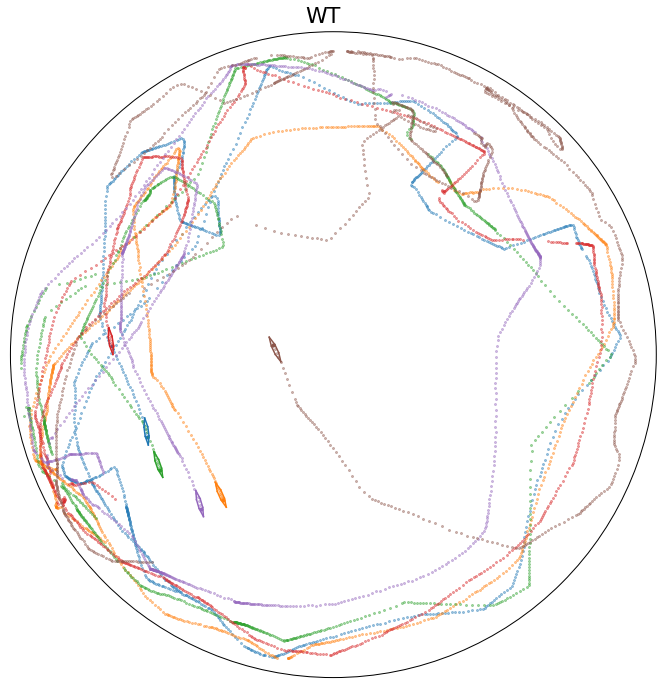

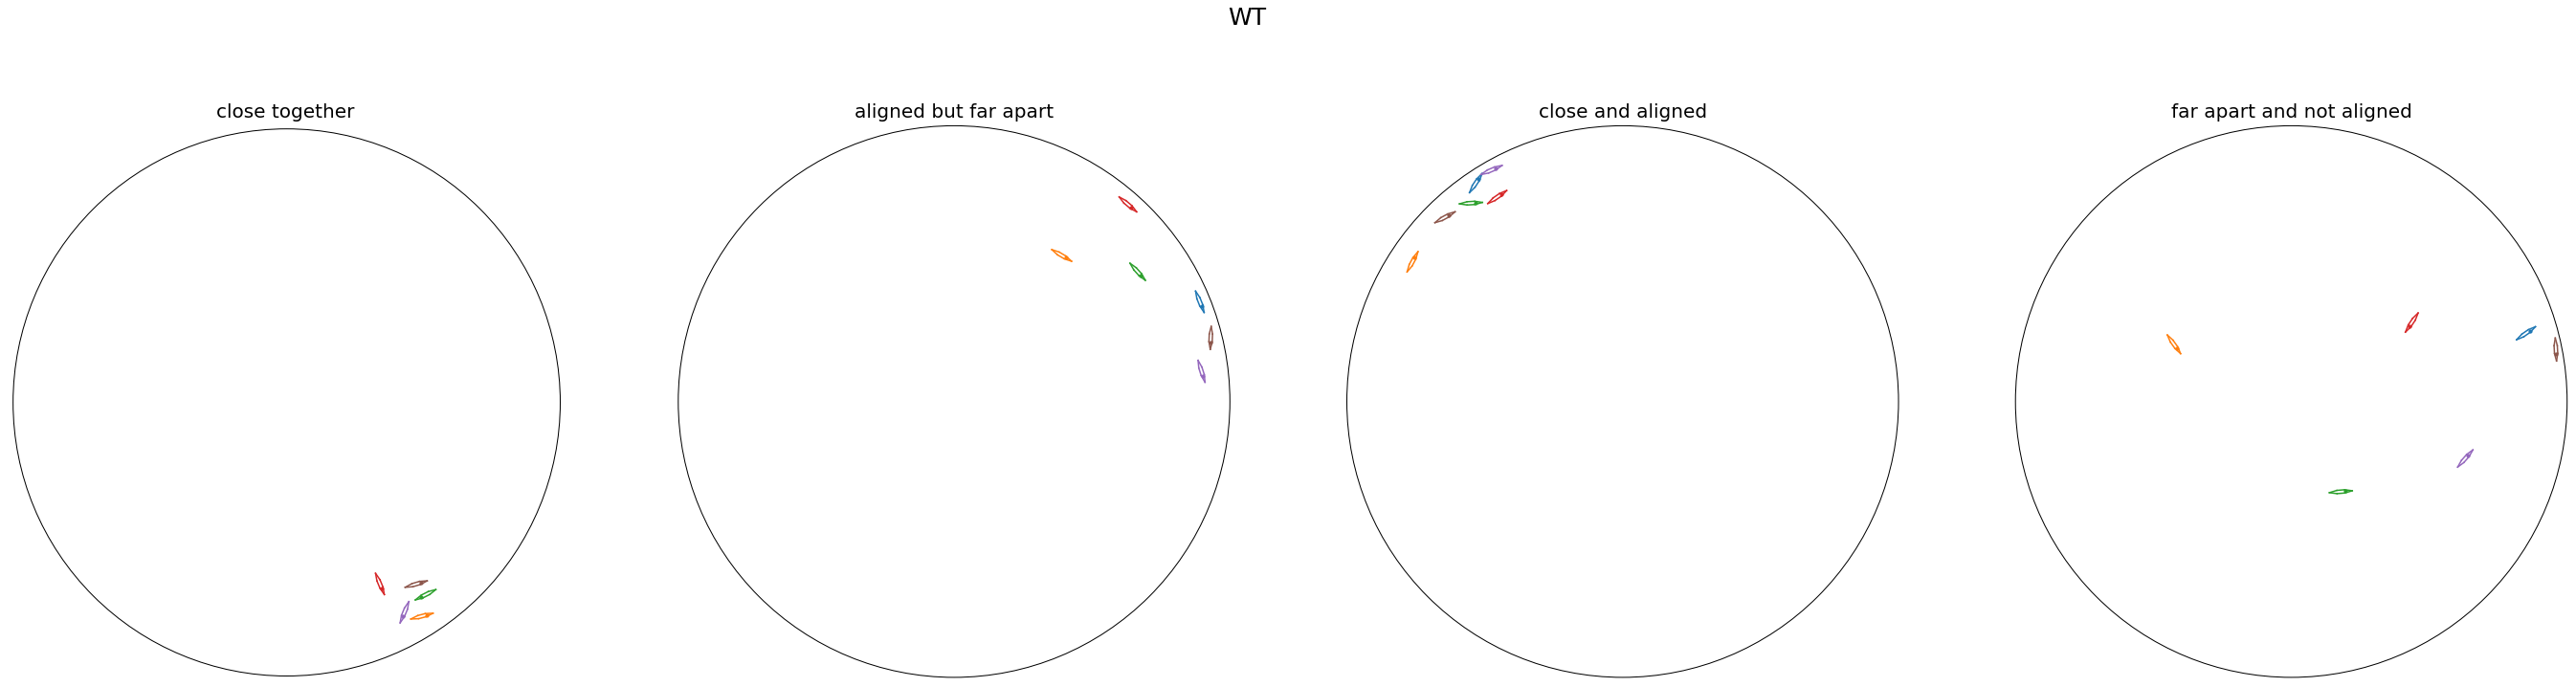

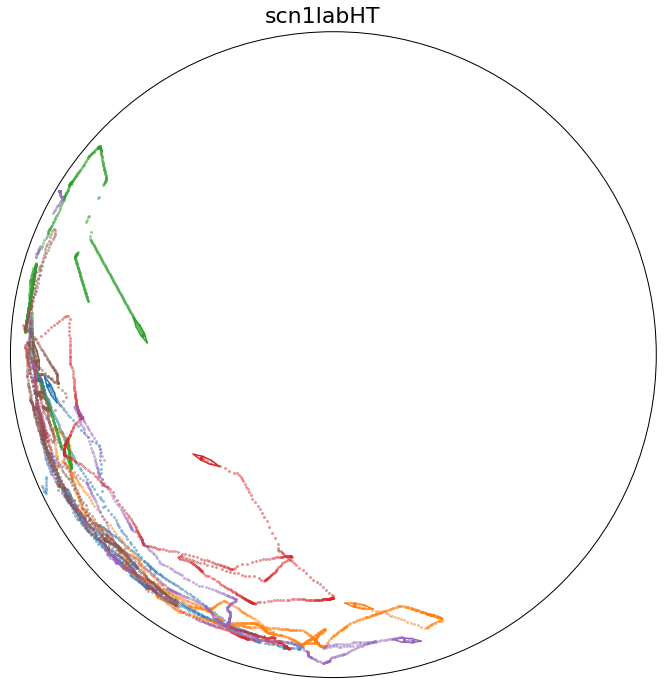

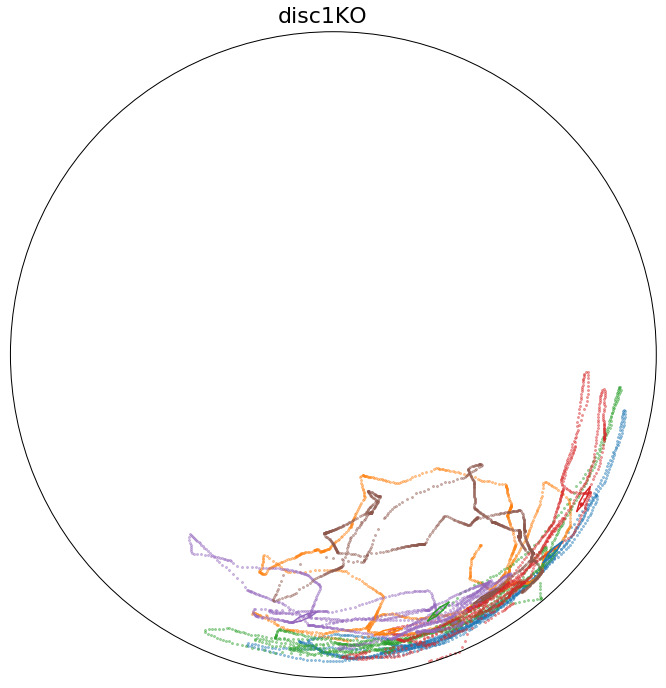

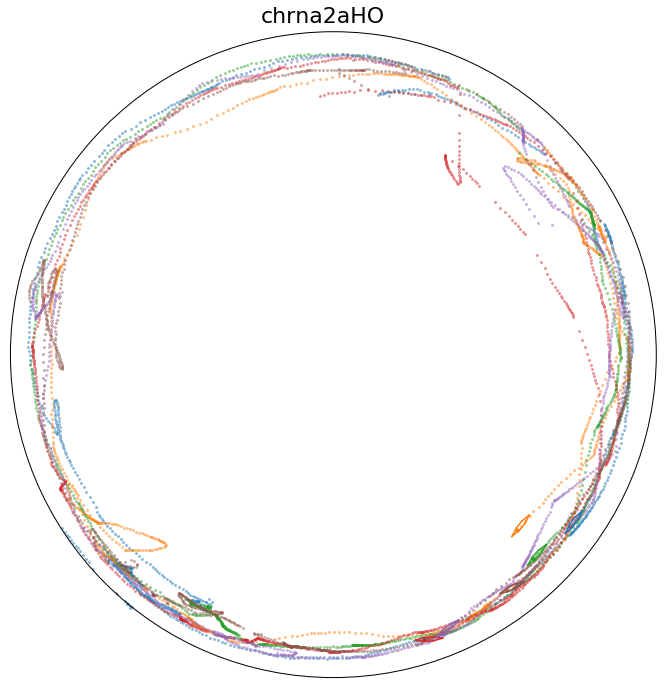

In [16]:
tnum=0
for tnum in [0, 4,50,2]:
    treatment = treatments[tnum]
    numtrials = allnumtrials[tnum]

    alldist, alldcoords_rotated, ellipses, smoothspeeds, theta, heading, smoothtrajectories, trialids, trackingerrors = dfunc.getcat(treatment,datadir,'all')  # do this, because it saves a lot on memory 

    numsteps = alldist.shape[0]
    numfish = alldist.shape[1]

    outfile = datadir+treatment+'-quantile+group+boundary.pkl'
    [speedquantiles10, speedquantiles20, ndistquantiles, bdistquantiles,
        groupcentroid, groupspeed, grouppolarization, grouprotation, groupiid, boundarydist,
        trial_arena_mid, trial_arena_r, overlaptimesteps    ] = pickle.load(open(outfile,'rb'))

    ind = np.where(focustreatments==tnum)[0][0]

    
    ## EXAMPLE IMAGES  
#     save the example image for this one
    showfig(focusexampleframes[ind],showlen=1000)
    plt.suptitle(treatment,fontsize=22, y=0.905)
#     plt.savefig(imagedir+'exampletraj-'+treatment+'.pdf',bbox='tight')
    plt.show()

    if tnum==0:
        f, ax = plt.subplots(1,4,sharex=True,sharey=True)
        f.set_size_inches(48,12)    
        [a.set_aspect(aspect=1) for a in ax]
        for i in range(len(WTexampleframes)):
            showfig(WTexampleframes[i],showlen=0,ax=ax[i])
            ax[i].set_title(WTexample_names[i],fontsize=20)
#         plt.savefig(imagedir+'WT-illustration-closefar-alignednot.pdf',bbox='tight')
        plt.suptitle(treatment,fontsize=25)
        plt.show()
        
    ### VIDEO OF THE HIGHLIGHTED SEGMENT
#     import matplotlib.animation as manimation
#     FFMpegWriter = manimation.writers['ffmpeg']
#     metadata = dict(title=treatment, artist='',comment='')
#     writer = FFMpegWriter(fps=30, metadata=metadata)    

#     f, ax = plt.subplots(1,1)
#     f.set_size_inches(12,12)
#     f.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#     with writer.saving(f, treatment+'-example-withlabel.mp4',dpi=300):    
#         for step in range(focusexampleframes[ind]+60-1000, focusexampleframes[ind],2):
#             ax.cla()
#             showfig(step,ax=ax,showlen=60)
#             plt.suptitle(treatment if tnum==0 else treatment[:-2],fontsize=24,y=0.9)            
#             plt.suptitle(textlabels[ind],fontsize=20,y=0.9)                        
#             writer.grab_frame()
#             if np.mod(step,2000)==0:
#                 print(step)

    plt.show()    